In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

In [85]:
def get_range(radius, resolution):
    re = [0]
    num = int(radius / resolution)
    # print("num => %s" %str(num))
    for i in range(num):
        re.append((i+1) * resolution)
        # re.append(-(i+1) * resolution)
    return re

def sum_sqaure(a, b, c):
    re = (a * a) + (b * b) + (c * c)
    return re

def loop_sphere(radius, resolution):
    re = []

    if radius <= 0:
        return re

    if resolution > radius:
        resolution = radius

    set_range = get_range(radius, resolution)
    # print("set_range => %s" %str(set_range))

    limit_sq_max = (radius + resolution)
    limit_sq_min = (radius - resolution)

    len_range = len(set_range)

    # tot_points = list()
    tot_points = set()
    for (i_z, z) in enumerate(set_range):
        # i_x = len_range - i_z - 1
        i_x = len_range - 1
        while i_x >= i_z:
            i_y = len_range - i_x - 1
            i_y = 0
            while i_x >= i_y:
                s = sum_sqaure(set_range[i_x], set_range[i_y], set_range[i_z])
                # print(s)
                if s >= limit_sq_min and s <= limit_sq_max:
                    for s_x in [-1, 1]:
                        for s_y in [-1, 1]:
                            for s_z in [-1, 1]:
                                p1 = (s_x * set_range[i_x], s_y * set_range[i_y], s_z * set_range[i_z])
                                p2 = (s_x * set_range[i_y], s_y * set_range[i_x], s_z * set_range[i_z])
                                p3 = (s_x * set_range[i_z], s_y * set_range[i_y], s_z * set_range[i_x])
                                p4 = (s_x * set_range[i_z], s_y * set_range[i_x], s_z * set_range[i_y])
                                for p in [p1, p2, p3, p4]:
                                    tot_points.add(p)
                i_y += 1
            i_x -= 1
    print(len(tot_points))     
    # print(tot_points)        
    l_x = []
    l_y = []
    l_z = []
    for l in tot_points:
        l_x.append(l[0])
        l_y.append(l[1])
        l_z.append(l[2])
    # print(l_x)
    return (l_x, l_y, l_z)

125818


Text(0.5, 0, 'Z')

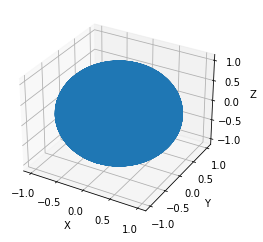

In [86]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs,ys,zs = loop_sphere(1, 0.01)
# print(xs)
ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# plt.show()